In [1]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

In [14]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data,mat_fie_sub, path_to_orig, path_to_resampled, mod = None):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
#         print('data')
#         print(data.shape)
        old_orig = ants.image_read(path_to_resampled)
#         print('old_orig')
#         print(old_orig.shape)
        
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        if mod == '3a_atlas':
#             print('a')
            new_img = ants.apply_transforms(new_orig, old_like, whichtoinvert=[True],
                                      transformlist = mat_fie_sub)
        elif mod == '2a_interp':
#             print('cehck')
            new_img = ants.resample_image(old_like, new_orig.shape, True, 0)
        else:
            new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
#         print('new_img')
#         print(new_img.shape)
        output_file = new_img.numpy().astype('float16')
#         print(new_orig.shape)
#         print(output_file.shape)
#         print(new_orig.shape)
        if (new_orig.shape[0]-output_file.shape[0] < 0 ) or (new_orig.shape[1]-output_file.shape[1] < 0) or (new_orig.shape[2]-output_file.shape[2] < 0):
            print('1')
            output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
        if (new_orig.shape[0]-output_file.shape[0] > 0) or (new_orig.shape[1]-output_file.shape[1] > 0) or (new_orig.shape[2]-output_file.shape[2] > 0):
            print('2')
            output_file = np.pad(output_file, ((0, new_orig.shape[0]-output_file.shape[0]), (0, new_orig.shape[1]-output_file.shape[1]), (0, new_orig.shape[2]-output_file.shape[2])), 'constant', constant_values=0)

#         output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
#         print(output_file.shape)
#         print(output_file.shape)
        return (output_file)
    
def pred_invert_resample_classes(data, mat_file_path, path_to_orig, path_to_resampled, mod):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')
#         print(data.shape)
        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)
    
#         print(old_orig_ct1.shape)
#         print(new_orig_ct1.shape)
        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])
#         print('old_like')
# #         print(old_like_ch_2.shape)
        if mod == '2a_interp':
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.shape, True, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.shape, True, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.shape, True, 0)
        if mod == '3a_atlas':
            new_img_0 = ants.apply_transforms(new_orig_ct1, old_like_ch_0, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_1 = ants.apply_transforms(new_orig_ct1, old_like_ch_1, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_2 = ants.apply_transforms(new_orig_ct1, old_like_ch_2, whichtoinvert=[True],
                                          transformlist = mat_file_path)
        else:
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)
       
        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.astype('float16')
#         print(output_file.shape)
#         print('check_shape')
#         print(new_orig_ct1.shape)
#         print(new_orig_ct1.shape[2]-output_file.shape[3])
#         print((new_orig_ct1.shape[1]-output_file.shape[2]))
#         print((new_orig_ct1.shape[0]-output_file.shape[1]))
        if (new_orig_ct1.shape[2]-output_file.shape[3] < 0 ) or (new_orig_ct1.shape[1]-output_file.shape[2] < 0) or (new_orig_ct1.shape[0]-output_file.shape[1] < 0):
            print(1)
            output_file = output_file[:, :new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
            
        if (new_orig_ct1.shape[2]-output_file.shape[3] > 0) or (new_orig_ct1.shape[1]-output_file.shape[2] > 0 ) or (new_orig_ct1.shape[0]-output_file.shape[1] > 0):
            print(2)
            output_file = np.pad(output_file, ((0,0), (0, new_orig_ct1.shape[0]-output_file.shape[1]), (0, new_orig_ct1.shape[1]-output_file.shape[2]), (0, new_orig_ct1.shape[2]-output_file.shape[3])), 'constant', constant_values=0)

        output_file = output_file[:,:new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
#         print(output_file.shape)
        
        return (output_file)

In [3]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)

In [4]:
def calculate_metrics_brats_1cl(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1',
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_3'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_3'] = sens
    df.at[0,'Precision_3'] = precision
    df.at[0,'Specificity_3'] = spec
    return df

In [184]:
    
def calculate_metrics(subjects, path_to_file, path_to_orig, path_to_pred, path_to_resamp, path_to_target, dataset, out = '/home/polina/glioma/all_dice_metrics.csv', mod=None  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
#     _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
#                 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
#                 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
#                'Specificity_1', 'Specificity_2', 'Specificity_3',
#                'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
#                'Precision_1', 'Precision_2', 'Precision_3']
    _columns = ['Ids','Dice_1',
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    orig_folder = Path(path_to_orig)
    resamp_folder = Path(path_to_resamp)
    target_folder = Path(path_to_target)
    file_folder = Path(path_to_file)
    for ids in tqdm(subjects):
        print(ids)
        pred_sub = os.path.join(pred_folder, ids + '.npy.npz')
        orig_sub = os.path.join(orig_folder, ids,'CT1_SEG.nii.gz')
#         orig_sub = os.path.join(orig_folder, ids,'T1_SEG.nii.gz')
        resamp_sub = os.path.join(resamp_folder, ids,'CT1_SEG.nii.gz')
#         resamp_sub = os.path.join(resamp_folder, ids,'T1_SEG.nii.gz')
        mat_fie_sub = os.path.join(file_folder, ids,'T1C_to_SRI_inv.mat')
#         targets = nib.load(os.path.join(target_folder, ids + '_seg.nii.gz'))
#         targets = ants.image_read(orig_sub)
#         targets = ants.reorient_image2(label_orig, orientation = 'LAI')
#         targets = nib.load(orig_sub)
#         spaces = targets.header.get_zooms()
#         spaces = targets.spacing
#         targets = targets.numpy().astype('int')
        targets = ants.image_read(f'{target_folder}/{ids}/CT1_SEG.nii.gz')
#         targets = ants.image_read(f'{target_folder}/{ids}/T1_SEG.nii.gz')
        spaces = targets.spacing
#         targets = ants.reorient_image2(targets, orientation = 'LAI').numpy()
        targets = targets.numpy()
#         print(targets.shape)
#         print(np.unique(targets))
        data = np.load(pred_sub, allow_pickle=True)['arr_0']
#         print(data.shape)
        if np.shape(data)[0] == 1: 
#             print('check')
#             print(ants.image_read(orig_sub).shape)
#             print(targets.shape)
            prediction = pred_invert_resample_1cl(data, mat_fie_sub, orig_sub, resamp_sub, mod)
            prediction = np.round(prediction, 0)
#         pred = np.transpose(pred, (0, 3, 2, 1))
#             print(prediction.shape)
#             print(np.unique(prediction))
#             print(targets.shape)
#             print(prediction.shape)
            y_wt = targets > 0
            df = calculate_metrics_brats_1cl(y_wt.astype('int'), prediction.astype('int'), ids, spaces)
            print(df)
        elif np.shape(data)[0] > 1: 
            prediction = pred_invert_resample_classes(data, mat_fie_sub, orig_sub, resamp_sub, mod)
#             prediction = data.transpose(0,3,2,1).astype('float32')
            prediction = np.round(prediction, 0)
            y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
            targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
#             print(targets.shape)
#             print(prediction.shape)
            df=calculate_metrics_brats(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             print(df)
#             except:
#                 continue
        os.makedirs(os.path.join(out, dataset,ids), exist_ok = True)
#         print(path_to_pred)
#         out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('best_')[-1].replace('=', '_') + '.json')
        out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('predictions_')[-1].replace('=', '_') + '.json')
       #         df.to_json(out_path, orient='records')
        sub_dict = {dataset : {path_to_pred.split('/')[-2]: {path_to_pred.split('_')[-2]: {}}}}
        sub_dict[dataset][path_to_pred.split('/')[-2]][path_to_pred.split('_')[-2]] = df.to_dict('records')[0]
#         print(sub_dict)
        with open(out_path, 'w') as fp:
            json.dump(sub_dict, fp)
#         print(df)
        af_all = af_all.append(df)
#     af_all.to_csv(out)  
    print(af_all.mean())
    print(len(af_all))
    return af_all

In [201]:
!cd /data/newdata/gbm_results/gbm_5_ss_shared_from_egd_TL/fold-1/checkpoints/ && ls -l

/bin/bash: line 0: cd: /data/newdata/gbm_results/gbm_5_ss_shared_from_egd_TL/fold-1/checkpoints/: No such file or directory


In [202]:
!cd /data/newdata/gbm_infer/gbm_5_ss_shared_from_egd_TL && ls -l

total 12
drwxr-xr-x 2 root root 4096 Nov 24 18:58 'predictions_best_epoch=26-dice_mean=76_08_task=28_fold=2_tta'
drwxr-xr-x 2 root root 4096 Nov 24 16:08 'predictions_best_epoch=29-dice_mean=77_09_task=28_fold=0_tta'
drwxr-xr-x 2 root root 4096 Nov 24 17:34 'predictions_best_epoch=40-dice_mean=73_99_task=28_fold=1_tta'


In [70]:
len(os.listdir('/data_anvar/public_datasets/preproc_study/gbm/4a_resamp'))

102

In [164]:
len(os.listdir('/data/newdata/gbm_infer/gbm_1_reg_train_from_bgpd_TL/predictions_best_epoch=73-dice_mean=82_71_task=21_fold=2_tta'))

22

In [205]:
orig_folder = '/data_anvar/public_datasets/preproc_study/gbm/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/gbm/4a_resamp'
file = '/data_anvar/public_datasets/preproc_study/gbm/3a_atlas'
pred_folder = '/data/newdata/gbm_infer/gbm_5_ss_shared_from_egd_TL/predictions_best_epoch=26-dice_mean=76_08_task=28_fold=2_tta'
target_folder = '/data_anvar/public_datasets/preproc_study/gbm/1_reg'
reg_1 = '/data_anvar/public_datasets/preproc_study/gbm/1_reg'
out_json = '/results/metrics'
dataset = 'gbm'
# TCGA-76-4932
subjects = [each[:-8] for each in os.listdir(pred_folder)]
assert(len(subjects) == 102)
# subjects = ['TCGA-02-0027']
calculate_metrics(subjects, file, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json)

  0%|                                                                       | 0/102 [00:00<?, ?it/s]

TCGA-02-0054


  1%|▌                                                              | 1/102 [00:02<03:28,  2.07s/it]

TCGA-06-0164


  2%|█▏                                                             | 2/102 [00:05<05:07,  3.07s/it]

TCGA-19-0963


  3%|█▊                                                             | 3/102 [00:07<04:19,  2.62s/it]

TCGA-02-0075


  4%|██▍                                                            | 4/102 [00:10<04:02,  2.47s/it]

TCGA-02-0046


  5%|███                                                            | 5/102 [00:12<03:45,  2.33s/it]

TCGA-08-0356


  6%|███▋                                                           | 6/102 [00:18<06:07,  3.83s/it]

TCGA-06-0145


  7%|████▎                                                          | 7/102 [00:22<06:06,  3.86s/it]

TCGA-02-0087


  8%|████▉                                                          | 8/102 [00:44<15:01,  9.59s/it]

TCGA-02-0027


  9%|█████▌                                                         | 9/102 [01:06<20:51, 13.46s/it]

TCGA-76-4934


 10%|██████                                                        | 10/102 [01:10<15:49, 10.32s/it]

TCGA-12-1098
1


 11%|██████▋                                                       | 11/102 [01:21<16:12, 10.68s/it]

TCGA-19-1789


 12%|███████▎                                                      | 12/102 [01:31<15:41, 10.46s/it]

TCGA-14-1456


 13%|███████▉                                                      | 13/102 [01:36<13:12,  8.91s/it]

TCGA-76-6662


 14%|████████▌                                                     | 14/102 [01:39<10:29,  7.16s/it]

TCGA-06-1084


 15%|█████████                                                     | 15/102 [01:43<08:39,  5.98s/it]

TCGA-19-2631
1


 16%|█████████▋                                                    | 16/102 [01:45<06:51,  4.79s/it]

TCGA-06-0177


 17%|██████████▎                                                   | 17/102 [01:49<06:39,  4.70s/it]

TCGA-06-0187


 18%|██████████▉                                                   | 18/102 [01:54<06:29,  4.64s/it]

TCGA-08-0522


 19%|███████████▌                                                  | 19/102 [02:01<07:29,  5.41s/it]

TCGA-06-0185


 20%|████████████▏                                                 | 20/102 [02:04<06:19,  4.62s/it]

TCGA-19-5954


 21%|████████████▊                                                 | 21/102 [02:14<08:28,  6.28s/it]

TCGA-76-6285


 22%|█████████████▎                                                | 22/102 [02:16<06:49,  5.12s/it]

TCGA-12-3650


 23%|█████████████▉                                                | 23/102 [02:21<06:41,  5.09s/it]

TCGA-08-0359


 24%|██████████████▌                                               | 24/102 [02:27<06:49,  5.25s/it]

TCGA-02-0059


 25%|███████████████▏                                              | 25/102 [02:32<06:49,  5.31s/it]

TCGA-06-0139


 25%|███████████████▊                                              | 26/102 [02:47<10:09,  8.02s/it]

TCGA-12-1601
1


 26%|████████████████▍                                             | 27/102 [02:50<08:05,  6.48s/it]

TCGA-08-0355


 27%|█████████████████                                             | 28/102 [02:56<07:50,  6.36s/it]

TCGA-06-0179


 28%|█████████████████▋                                            | 29/102 [03:09<10:26,  8.58s/it]

TCGA-19-5951
1


 29%|██████████████████▏                                           | 30/102 [03:12<08:00,  6.67s/it]

TCGA-19-2624


 30%|██████████████████▊                                           | 31/102 [03:22<09:08,  7.73s/it]

TCGA-76-6663


 31%|███████████████████▍                                          | 32/102 [03:24<07:09,  6.13s/it]

TCGA-12-1598
1


 32%|████████████████████                                          | 33/102 [03:26<05:29,  4.77s/it]

TCGA-14-1825
1


 33%|████████████████████▋                                         | 34/102 [03:28<04:35,  4.05s/it]

TCGA-06-0142


 34%|█████████████████████▎                                        | 35/102 [03:32<04:33,  4.08s/it]

TCGA-12-0776


 35%|█████████████████████▉                                        | 36/102 [03:37<04:41,  4.26s/it]

TCGA-06-0238


 36%|██████████████████████▍                                       | 37/102 [03:53<08:18,  7.67s/it]

TCGA-12-0616


 37%|███████████████████████                                       | 38/102 [03:58<07:28,  7.01s/it]

TCGA-06-0184


 38%|███████████████████████▋                                      | 39/102 [04:03<06:38,  6.32s/it]

TCGA-06-0190


 39%|████████████████████████▎                                     | 40/102 [04:08<06:04,  5.88s/it]

TCGA-19-5958


 40%|████████████████████████▉                                     | 41/102 [04:18<07:18,  7.19s/it]

TCGA-06-0154


 41%|█████████████████████████▌                                    | 42/102 [04:22<06:15,  6.26s/it]

TCGA-02-0070


 42%|██████████████████████████▏                                   | 43/102 [04:24<05:00,  5.09s/it]

TCGA-08-0520


 43%|██████████████████████████▋                                   | 44/102 [04:31<05:27,  5.65s/it]

TCGA-76-4932


 44%|███████████████████████████▎                                  | 45/102 [04:33<04:22,  4.61s/it]

TCGA-14-3477
1


 45%|███████████████████████████▉                                  | 46/102 [04:37<04:07,  4.43s/it]

TCGA-02-0034


 46%|████████████████████████████▌                                 | 47/102 [04:40<03:26,  3.75s/it]

TCGA-06-0122


 47%|█████████████████████████████▏                                | 48/102 [04:52<05:41,  6.33s/it]

TCGA-76-6656


 48%|█████████████████████████████▊                                | 49/102 [04:55<04:42,  5.32s/it]

TCGA-76-6280


 49%|██████████████████████████████▍                               | 50/102 [04:58<03:54,  4.50s/it]

TCGA-02-0033


 50%|███████████████████████████████                               | 51/102 [05:00<03:10,  3.74s/it]

TCGA-02-0006


 51%|███████████████████████████████▌                              | 52/102 [05:02<02:42,  3.24s/it]

TCGA-06-5413


 52%|████████████████████████████████▏                             | 53/102 [05:16<05:18,  6.50s/it]

TCGA-76-6661


 53%|████████████████████████████████▊                             | 54/102 [05:18<04:07,  5.15s/it]

TCGA-08-0509


 54%|█████████████████████████████████▍                            | 55/102 [05:24<04:23,  5.61s/it]

TCGA-06-0176


 55%|██████████████████████████████████                            | 56/102 [05:29<04:00,  5.23s/it]

TCGA-06-0138


 56%|██████████████████████████████████▋                           | 57/102 [05:42<05:41,  7.59s/it]

TCGA-02-0037


 57%|███████████████████████████████████▎                          | 58/102 [05:44<04:20,  5.93s/it]

TCGA-02-0106


 58%|███████████████████████████████████▊                          | 59/102 [05:46<03:24,  4.76s/it]

TCGA-06-0240


 59%|████████████████████████████████████▍                         | 60/102 [05:51<03:23,  4.84s/it]

TCGA-06-0158


 60%|█████████████████████████████████████                         | 61/102 [05:55<03:06,  4.55s/it]

TCGA-02-0086


 61%|█████████████████████████████████████▋                        | 62/102 [05:57<02:33,  3.83s/it]

TCGA-06-6389


 62%|██████████████████████████████████████▎                       | 63/102 [06:05<03:21,  5.16s/it]

TCGA-08-0512


 63%|██████████████████████████████████████▉                       | 64/102 [06:12<03:37,  5.72s/it]

TCGA-06-0130


 64%|███████████████████████████████████████▌                      | 65/102 [06:27<05:08,  8.33s/it]

TCGA-08-0360


 65%|████████████████████████████████████████                      | 66/102 [06:33<04:41,  7.82s/it]

TCGA-02-0116


 66%|████████████████████████████████████████▋                     | 67/102 [06:35<03:33,  6.09s/it]

TCGA-06-0644


 67%|█████████████████████████████████████████▎                    | 68/102 [06:49<04:39,  8.23s/it]

TCGA-08-0390


 68%|█████████████████████████████████████████▉                    | 69/102 [06:56<04:21,  7.92s/it]

TCGA-06-5408


 69%|██████████████████████████████████████████▌                   | 70/102 [07:00<03:41,  6.92s/it]

TCGA-14-1794


 70%|███████████████████████████████████████████▏                  | 71/102 [07:06<03:22,  6.53s/it]

TCGA-06-5417


 71%|███████████████████████████████████████████▊                  | 72/102 [07:20<04:24,  8.83s/it]

TCGA-08-0385


 72%|████████████████████████████████████████████▎                 | 73/102 [07:27<03:58,  8.24s/it]

TCGA-12-0829
1


 73%|████████████████████████████████████████████▉                 | 74/102 [07:31<03:11,  6.84s/it]

TCGA-06-0646


 74%|█████████████████████████████████████████████▌                | 75/102 [07:44<03:55,  8.70s/it]

TCGA-76-4935


 75%|██████████████████████████████████████████████▏               | 76/102 [07:47<03:02,  7.03s/it]

TCGA-06-1802


 75%|██████████████████████████████████████████████▊               | 77/102 [07:53<02:50,  6.81s/it]

TCGA-76-6664


 76%|███████████████████████████████████████████████▍              | 78/102 [07:55<02:10,  5.44s/it]

TCGA-02-0068


 77%|████████████████████████████████████████████████              | 79/102 [07:58<01:42,  4.47s/it]

TCGA-06-0149


 78%|████████████████████████████████████████████████▋             | 80/102 [08:10<02:34,  7.01s/it]

TCGA-76-6191


 79%|█████████████████████████████████████████████████▏            | 81/102 [08:13<02:00,  5.73s/it]

TCGA-06-0137


 80%|█████████████████████████████████████████████████▊            | 82/102 [08:17<01:42,  5.12s/it]

TCGA-02-0011


 81%|██████████████████████████████████████████████████▍           | 83/102 [08:19<01:20,  4.21s/it]

TCGA-06-0182


 82%|███████████████████████████████████████████████████           | 84/102 [08:24<01:20,  4.48s/it]

TCGA-06-0162


 83%|███████████████████████████████████████████████████▋          | 85/102 [08:28<01:13,  4.33s/it]

TCGA-08-0392


 84%|████████████████████████████████████████████████████▎         | 86/102 [08:35<01:22,  5.13s/it]

TCGA-02-0064


 85%|████████████████████████████████████████████████████▉         | 87/102 [08:57<02:34, 10.31s/it]

TCGA-02-0102


 86%|█████████████████████████████████████████████████████▍        | 88/102 [08:59<01:49,  7.81s/it]

TCGA-02-0047


 87%|██████████████████████████████████████████████████████        | 89/102 [09:02<01:19,  6.10s/it]

TCGA-76-6657


 88%|██████████████████████████████████████████████████████▋       | 90/102 [09:04<01:01,  5.14s/it]

TCGA-76-6193


 89%|███████████████████████████████████████████████████████▎      | 91/102 [09:26<01:50, 10.02s/it]

TCGA-06-0119


 90%|███████████████████████████████████████████████████████▉      | 92/102 [09:29<01:20,  8.05s/it]

TCGA-02-0069


 91%|████████████████████████████████████████████████████████▌     | 93/102 [09:52<01:50, 12.30s/it]

TCGA-12-1094


 92%|█████████████████████████████████████████████████████████▏    | 94/102 [09:54<01:14,  9.34s/it]

TCGA-19-5960


 93%|█████████████████████████████████████████████████████████▋    | 95/102 [09:56<00:50,  7.23s/it]

TCGA-08-0389


 94%|██████████████████████████████████████████████████████████▎   | 96/102 [10:03<00:42,  7.05s/it]

TCGA-02-0009


 95%|██████████████████████████████████████████████████████████▉   | 97/102 [10:05<00:27,  5.51s/it]

TCGA-06-2570


 96%|███████████████████████████████████████████████████████████▌  | 98/102 [10:17<00:30,  7.66s/it]

TCGA-06-0188


 97%|████████████████████████████████████████████████████████████▏ | 99/102 [10:22<00:20,  6.67s/it]

TCGA-76-6282


 98%|███████████████████████████████████████████████████████████▊ | 100/102 [10:45<00:23, 11.58s/it]

TCGA-02-0085


 99%|████████████████████████████████████████████████████████████▍| 101/102 [10:47<00:08,  8.68s/it]

TCGA-06-0192


100%|█████████████████████████████████████████████████████████████| 102/102 [11:00<00:00,  6.48s/it]

Dice_1            0.865342
Hausdorff95_1     8.866530
Sensitivity_1     0.809278
Specificity_1     0.999395
Surface_dice_1    0.664439
Precision_1       0.938384
Dice_2            0.823251
Dice_3            0.763117
Hausdorff95_2     6.641067
Hausdorff95_3     6.447890
Sensitivity_2     0.771183
Sensitivity_3     0.705646
Specificity_2     0.999620
Specificity_3     0.999563
Surface_dice_2    0.641281
Surface_dice_3    0.743513
Precision_2       0.907459
Precision_3       0.851181
dtype: float64
102


,Ids,Dice_1,Hausdorff95_1,Sensitivity_1,Specificity_1,Surface_dice_1,Precision_1,Dice_2,Dice_3,Hausdorff95_2,Hausdorff95_3,Sensitivity_2,Sensitivity_3,Specificity_2,Specificity_3,Surface_dice_2,Surface_dice_3,Precision_2,Precision_3
0,TCGA-02-0054,0.894623,6.101758,0.828601,0.999672,0.789113,0.972077,0.750141,0.856866,8.013904,6.5,0.604176,0.809982,0.999971,0.999766,0.557034,0.822721,0.989101,0.909512
0,TCGA-06-0164,0.913287,2.8125,0.87054,0.99958,0.834275,0.96045,0.927116,0.814848,3.0,3.75,0.929205,0.859882,0.999707,0.999491,0.821308,0.879084,0.925037,0.774297
0,TCGA-19-0963,0.662502,22.5,0.553546,0.99699,0.278378,0.824861,0.698469,0.281256,16.657351,22.58951,0.680741,0.512751,0.995541,0.987601,0.424448,0.436194,0.717146,0.193773
0,TCGA-02-0075,0.758506,8.207305,0.6146,0.999889,0.585417,0.990407,0.420459,0.672605,15.208961,13.587912,0.26696,0.523327,0.999985,0.999936,0.214786,0.560802,0.989292,0.941033
0,TCGA-02-0046,0.780944,10.282342,0.709258,0.997012,0.537376,0.86875,0.796803,0.688981,6.546782,6.546782,0.6811,0.570421,0.999785,0.999426,0.538383,0.605072,0.95986,0.869756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,TCGA-06-2570,0.913553,3.12512,0.882895,0.999664,0.765638,0.946417,0.941358,0.82641,2.5,2.5,0.950036,0.797831,0.999687,0.999738,0.852086,0.922407,0.932837,0.857112
0,TCGA-06-0188,0.924717,2.8125,0.967568,0.999426,0.870672,0.885501,0.879922,0.873718,1.875,6.825103,0.866988,0.866998,0.999952,0.999947,0.917587,0.918254,0.893247,0.880544
0,TCGA-76-6282,0.944403,3.072369,0.927944,0.999249,0.685474,0.961457,0.921499,0.790089,3.322508,4.875,0.941394,0.686634,0.999268,0.999776,0.640819,0.72786,0.902427,0.930249
0,TCGA-02-0085,0.959637,1.104854,0.931257,0.999836,0.953549,0.989801,0.915193,0.888306,6.5,4.555431,0.855296,0.837372,0.999934,0.999804,0.860944,0.898509,0.984111,0.945837


In [167]:
!cd /data/newdata/schw_infer/schw_3a_atlas_from_brats_TL && ls

'predictions_best_epoch=54-dice_mean=85_84_task=37_fold=2_tta'
'predictions_best_epoch=87-dice_mean=87_01_task=37_fold=0_tta'
'predictions_best_epoch=96-dice_mean=85_73_task=37_fold=1_tta'


In [169]:
len(os.listdir('/data/newdata/schw_infer/schw_3a_atlas_from_brats_TL/predictions_best_epoch=87-dice_mean=87_01_task=37_fold=0_tta'))

242

In [177]:
orig_folder = '/data_anvar/public_datasets/preproc_study/schw/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/schw/3a_atlas'
file = '/data_anvar/public_datasets/preproc_study/schw/3a_atlas'
pred_folder = '/data/newdata/schw_infer/schw_3a_atlas_from_brats_TL/predictions_best_epoch=87-dice_mean=87_01_task=37_fold=0_tta'
target_folder = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
reg_1 = '/data_anvar/public_datasets/preproc_study/schw/1_reg'
out_json = '/results/metrics'
dataset = 'schw'
# TCGA-76-4932
subjects = [each[:-8] for each in os.listdir(pred_folder)]
assert(len(subjects) == 242)
# subjects = ['TCGA-02-0027']
calculate_metrics(subjects, file, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json, mod='3a_atlas')

  0%|                                                                       | 0/242 [00:00<?, ?it/s]

VS-SEG-146


  0%|                                                                       | 0/242 [00:02<?, ?it/s]


Exception: Transform /data_anvar/public_datasets/preproc_study/schw/3a_atlas/VS-SEG-146/T1C_to_SRI_inv.mat does not exist

In [181]:
!cd /data_anvar/public_datasets/preproc_study/schw/orig/VS-SEG-001  && ls

T1.nii.gz  T1_SEG.nii.gz  T2.nii.gz


(256, 256, 23)
[10]
(1, 150, 200, 200)
(256, 256, 23, 3)
(256, 256, 23, 1)
[0 1]
(256, 256, 23)
[0 1]


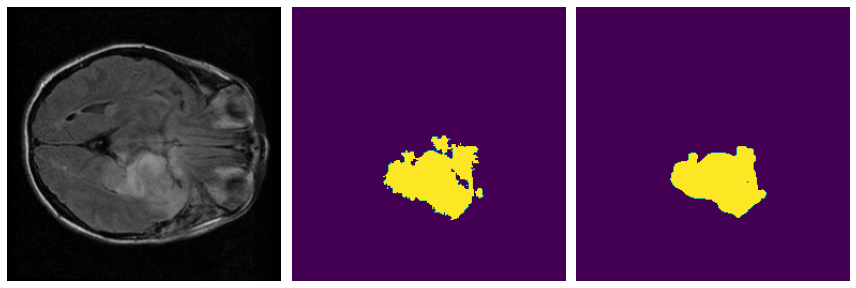

TCGA-02-0054
dice WT
0.8945247068676717


In [33]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-02-0054'

orig_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/gbm/1_reg'), fname,'CT1_SEG.nii.gz')
resamp_sub = os.path.join(Path('/data_anvar/public_datasets/preproc_study/gbm/4a_resamp'), fname,'CT1_SEG.nii.gz')

targets = ants.image_read(orig_sub)
targets = targets.numpy()
print(targets.shape)
l = np.argsort(targets.sum(axis=(0,1)))[-1:]
print(l)
y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)



img_orig = ants.image_read(os.path.join(Path('/data_anvar/public_datasets/preproc_study/gbm/1_reg'), fname,'FLAIR.nii.gz'))
img_orig = img_orig.numpy()[:,:,:,np.newaxis]


pred = np.load(f'/data/newdata/gbm_infer/gbm_4a_resamp_from_bgpd_TL/predictions_best_epoch=56-dice_mean=81_56_task=38_fold=0_tta/{fname}.npy.npz',allow_pickle=True)['arr_0']
print(pred.shape)
prediction = pred_invert_resample_1cl(pred, 'notnow', orig_sub, resamp_sub, mod=None)
p = np.round(prediction, 0).astype(np.uint8)
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:,:,l,0]] + [label_orig[:,:,l,0]]  +[p[:,:,l]] 
 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
for i in range(3):
        if i < 1:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

print(fname)
print('dice WT')
print(metrics.compute_dice_coefficient((label_orig[:,:,:]==1), (p[:,:,:]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))